# Optimized Overlapping Genes Simulation

This notebook runs the overlapping genes simulation using the **optimized** `overlappingGenes.py` module (Numba JIT compiled).
It also includes a comprehensive benchmarking suite comparing it against the original unoptimized code (`overlappingGenesoriginal.py`).

In [ ]:
import numpy as np
import time
import os
import multiprocessing as mp
from pathlib import Path
import pickle
import pandas as pd

import matplotlib.pyplot as plt

# Try importing seaborn for nicer plots, but fallback if missing
try:
    import seaborn as sns
    sns.set_context("talk",rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
    sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', 'xtick.bottom': True,'ytick.left': True})
    HAS_SEABORN = True
except ImportError:
    print("Seaborn not found. Using standard matplotlib styles.")
    plt.style.use('ggplot')
    HAS_SEABORN = False

import palettable as pal

colorTable = {}
colorTable['k'] = [0,0,0]
colorTable['g'] = [27/255,158/255,119/255]
colorTable['o'] = [217/255,95/255,2/255]

# Import from the OPTIMIZED module
from overlappingGenes import extract_params, initial_seq_no_stops, overlapped_sequence_generator_int, load_natural_energies

#### Functions

def load_data(family1,family2,verbose=False):
    """
    Load the data for a given pair of families.
    """
    dcaparams1 = root + family1 + '/' + family1 + '_params.dat'
    dcaparams2 = root + family2 + '/' + family2 + '_params.dat'

    Js_1, hs_1 = extract_params(dcaparams1)
    Js_2, hs_2 = extract_params(dcaparams2)

    # Length in amino acids, not including stop codons
    lenprot1 = len(hs_1)/21  # 21 is the number of amino acids incl blank
    lenprot2 = len(hs_2)/21  # 21 is the number of amino acids incl blank
   
    # Combining parameters
    DCA_params_1 = [Js_1, hs_1]
    DCA_params_2 = [Js_2, hs_2]

    return DCA_params_1, DCA_params_2, lenprot1, lenprot2

def process_single_overlap(params):
    """Process a single overlap combination and save results"""
    family1, family2, t1, t2, overlapLen = params
    
    # Create unique identifier for this run
    run_id = f"{family1}_{family2}_overlap{overlapLen}"
    
    # Load data
    DCA_params_1, DCA_params_2, lenprot1, lenprot2 = load_data(family1, family2)
        

    results = {}
    for rep in range(numreps):
        # Generate initial sequence
        initialCondition = initial_seq_no_stops(lenprot1, lenprot2, overlapLen,quiet=True)

        # Run simulation. Output is [seq, acceptedornot, energy_history_seq_1, energy_history_seq_2, finalenergies]
        # Note: The optimized function signature is the same, but runs much faster.
        output = overlapped_sequence_generator_int(DCA_params_1, DCA_params_2,
                                                initialCondition, 
                                                numberofiterations=numiter,
                                                T1=t1, T2=t2, quiet=True, whentosave=howoften)
        
        # Store only final results
        results[rep] = {
            'run_id': run_id,
            'initial_sequence': initialCondition,
            'final_sequence': output[0],
            'energy1': output[2],  # Energy time series for sequence 1
            'energy2': output[3],  # Energy time series for sequence 2
            'final_energies': output[4],  # Final energies for both sequences
            'parameters': {
                'family1': family1, 
                'family2': family2,
                'overlap': overlapLen,
                'T1': t1,
                'T2': t2,
                'num_iterations': numiter
            }
        }
    
    print(f"Completed {run_id}")

    return results

Seaborn not found. Using standard matplotlib styles.


ModuleNotFoundError: No module named 'palettable'

In [ ]:
#### Parameters

root = "./"

families = ['PF00004', 'PF00041']
family_temperatures = [0.8,0.93] # Temperatures for the two families, picked by Kabir to match natural sequence statistics

numiter = 50000   # Number of iterations for the sequence generator
numreps = 5       # How many independent replicates
howoften = 0.005  # How often to save the energy during generation. Multiply by 100 to get percentage of iterations

#### Overlap away

family1, family2 = families[0],families[1]
t1, t2 = family_temperatures[0], family_temperatures[1]

DCA_params_1, DCA_params_2, lenprot1, lenprot2 = load_data(family1, family2)
print(f"Prot1 Len: {lenprot1} AA, Prot2 Len: {lenprot2} AA")

overlapLength = 20
print(f"Running simulation with overlap {overlapLength}...")
start_time = time.time()
overlappingResults = process_single_overlap([family1, family2, t1, t2, overlapLength])
end_time = time.time()
print(f"Simulation finished in {end_time - start_time:.2f} seconds")

Prot1 Len: 110.0 AA, Prot2 Len: 74.0 AA
Running simulation with overlap 20...
Completed PF00004_PF00041_overlap20
Simulation finished in 5.12 seconds


In [ ]:
# Read in the energies of natural sequences
naturalenergies1_file = "./PF00004/PF00004_naturalenergies.txt"
naturalenergies2_file = "./PF00041/PF00041_naturalenergies.txt"

naturalenergies1 = load_natural_energies(naturalenergies1_file)
naturalenergies2 = load_natural_energies(naturalenergies2_file)
mean_1 = np.mean(naturalenergies1)
mean_2 = np.mean(naturalenergies2)
sd_1 = np.std(naturalenergies1)
sd_2 = np.std(naturalenergies2)

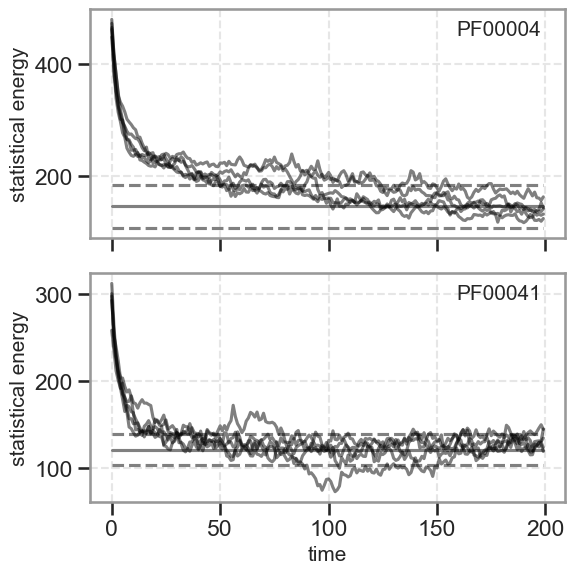

In [ ]:
#### Plot results

fig, axs = plt.subplots(2,1, sharex = True)
fig.set_size_inches(6,6)

xv = np.arange(len(overlappingResults[0]["energy1"]))
energy1 = overlappingResults[0]["energy1"] 
energy2 = overlappingResults[0]["energy2"]

xv = np.arange(len(overlappingResults[0]["energy1"]))
axs[0].plot(xv, np.ones_like(energy1)*mean_1, "-", color = "gray")
axs[0].plot(xv, np.ones_like(energy1)*(mean_1 + sd_1), "--", color = "gray")
axs[0].plot(xv, np.ones_like(energy1)*(mean_1 - sd_1), "--", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*mean_2, "-", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*(mean_2 + sd_2), "--", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*(mean_2 - sd_2), "--", color = "gray")

for rep in range(numreps):
    energy1 = overlappingResults[rep]["energy1"]
    energy2 = overlappingResults[rep]["energy2"]
    axs[0].plot(energy1, "k", alpha = 0.5)
    axs[1].plot(energy2, "k", alpha = 0.5)

axs[0].text(0.95, 0.95, f'{family1}', horizontalalignment='right',verticalalignment='top', transform=axs[0].transAxes)
axs[1].text(0.95, 0.95, f'{family2}', horizontalalignment='right',verticalalignment='top', transform=axs[1].transAxes)

axs[-1].set_xlabel("time")
axs[0].set_ylabel("statistical energy")
axs[1].set_ylabel("statistical energy")

plt.tight_layout()